In [7]:
import numpy as np
from shapely.geometry import LineString, Point
from math import sqrt
import osmnx as ox
import networkx as nx
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim

In [8]:
gdf = ox.geocode_to_gdf("Envigado, Antioquia, Colombia")
geom = gdf.geometry.iloc[0]

from shapely.geometry import Polygon, MultiPolygon
if geom.geom_type == 'MultiPolygon':
    geom = max(geom.geoms, key=lambda a: a.area)

In [9]:
#print(geom.geom_type)  # Debería decir 'Polygon'
print(geom.wkt)

POLYGON ((-75.6049283 6.1634166, -75.6048466 6.1633207, -75.604595 6.16309, -75.6044714 6.1628665, -75.6040828 6.1623351, -75.6035567 6.1615185, -75.6032539 6.1612268, -75.6021884 6.160143, -75.6024902 6.1599292, -75.6026311 6.1598889, -75.6027821 6.1598524, -75.6029521 6.1598073, -75.6031207 6.1597475, -75.603257 6.1596747, -75.6033845 6.1595727, -75.6034827 6.1594284, -75.603825 6.158902, -75.603903 6.1587915, -75.603988 6.1586604, -75.6040614 6.158543, -75.6041465 6.1584083, -75.6042306 6.1582709, -75.6043239 6.1581066, -75.6043451 6.1580672, -75.6043557 6.1580285, -75.6043524 6.1580003, -75.6042853 6.1579264, -75.6042763 6.1579165, -75.604215 6.1578491, -75.6040999 6.1576624, -75.6039681 6.1572768, -75.6039151 6.1569817, -75.6038363 6.1566097, -75.6038045 6.1564124, -75.6038045 6.1562738, -75.6037773 6.156069, -75.6037394 6.1560088, -75.6037167 6.1558175, -75.6037227 6.1556865, -75.6036288 6.1556082, -75.6034546 6.1556037, -75.6028595 6.1552588, -75.6023469 6.1544532, -75.6019355 6


# CÁLCULO DE HEURÍSTICA Y COSTO PERSONALIZADOS CON FACTORES REALES


# Parámetros de penalización

In [10]:

PENAL_SEMAFORO = 30      # segundos
FACTOR_ZONA_ESCOLAR = 1.2
PENAL_VIA_RESIDENCIAL = 1.1
DIST_SEMAFORO = 20       # metros
DIST_ESCUELA = 50        # metros

# Proyectar a UTM para medir distancias

In [11]:
G = ox.graph_from_place('Envigado, Antioquia, Colombia', network_type='drive',simplify=False)

# Agregar velocidades y tiempo de viaje

In [12]:
hwy_speeds = {'residential': 35, 'secondary': 50, 'tertiary': 60}
G = ox.add_edge_speeds(G, hwy_speeds=hwy_speeds)
G = ox.add_edge_travel_times(G)

G_proj = ox.project_graph(G)
gdf_nodes_proj, gdf_edges_proj = ox.graph_to_gdfs(G_proj, nodes=True, edges=True)

# Ruta

In [13]:
locator = Nominatim(user_agent='myGeocoder')

# Direcciones

In [14]:
location_start = locator.geocode('Sede Posgrados EIA, Envigado, Colombia')
location_end=locator.geocode('Universidad EIA, Envigado, Colombia')
print(location_start.address)
print(location_end.address)

Sede Posgrados EIA, Calle 25 Sur, La Magnolia, Envigado, Valle de Aburrá, Antioquia, RAP del Agua y la Montaña, 055422, Colombia
Escuela de Ingeniería de Antioquia, km 2+200, Vía Acceso P. Palmitas, Envigado, Valle de Aburrá, Antioquia, RAP del Agua y la Montaña, Colombia



# Descargar semáforos y escuelas

In [15]:
tags_ts = {'highway': 'traffic_signals'}
tags_school = {'amenity': 'school'}
gdf_ts = ox.features.features_from_place("Envigado, Antioquia, Colombia", tags=tags_ts).to_crs(G_proj.graph['crs'])
gdf_school = ox.features.features_from_place("Envigado, Antioquia, Colombia", tags=tags_school).to_crs(G_proj.graph['crs'])

# Preparar travel_time_penalizado

In [16]:

for u, v, k, data in G_proj.edges(keys=True, data=True):
    punto_u = Point(G_proj.nodes[u]['x'], G_proj.nodes[u]['y'])
    punto_v = Point(G_proj.nodes[v]['x'], G_proj.nodes[v]['y'])
    line = LineString([punto_u, punto_v])
    penal_tt = data['travel_time']

    if not gdf_ts.empty:
        dist_ts = gdf_ts.distance(line).min()
        if dist_ts <= DIST_SEMAFORO:
            penal_tt += PENAL_SEMAFORO

    if not gdf_school.empty:
        dist_school = gdf_school.distance(line).min()
        if dist_school <= DIST_ESCUELA:
            penal_tt *= FACTOR_ZONA_ESCOLAR


    tipo_via = data.get('highway', '')
    if isinstance(tipo_via, list):
        tipo_via = tipo_via[0]
    if tipo_via == 'residential':
        penal_tt *= PENAL_VIA_RESIDENCIAL

    data['travel_time_penalizado'] = penal_tt

# Recalcular heurística con velocidad máxima

In [17]:
all_speeds = [edata.get('speed_kph', 40) for _, _, _, edata in G_proj.edges(keys=True, data=True)]
vmax = max(all_speeds)
vmax_mps = vmax / 3.6

def heuristica_tiempo(u, v):
    x1, y1 = G_proj.nodes[u]['x'], G_proj.nodes[u]['y']
    x2, y2 = G_proj.nodes[v]['x'], G_proj.nodes[v]['y']
    distancia = sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distancia / vmax_mps

# Obtener nodos de inicio y fin

In [18]:
start= (location_start.latitude, location_start.longitude)
end= (location_end.latitude, location_end.longitude)
start_node = ox.distance.nearest_nodes(G, X=start[1], Y=start[0])
end_node = ox.distance.nearest_nodes(G, X=end[1], Y=end[0])

# Calcular ruta A* con travel_time_penalizado

In [19]:
ruta_astar = nx.astar_path(G_proj, start_node, end_node,
                           heuristic=lambda u, v=end_node: heuristica_tiempo(u, v),
                           weight='travel_time_penalizado')

# Resultados

In [20]:
tiempo_total = sum(G_proj.edges[u, v, 0]['travel_time_penalizado'] for u, v in zip(ruta_astar[:-1], ruta_astar[1:]))
distancia_total = sum(G_proj.edges[u, v, 0]['length'] for u, v in zip(ruta_astar[:-1], ruta_astar[1:]))

print(f"La mejor ruta considerando heurística realista y penalizaciones tiene {distancia_total:.0f} m y tarda {tiempo_total:.1f} segundos.")

La mejor ruta considerando heurística realista y penalizaciones tiene 15999 m y tarda 1347.1 segundos.


# Dibujar la ruta

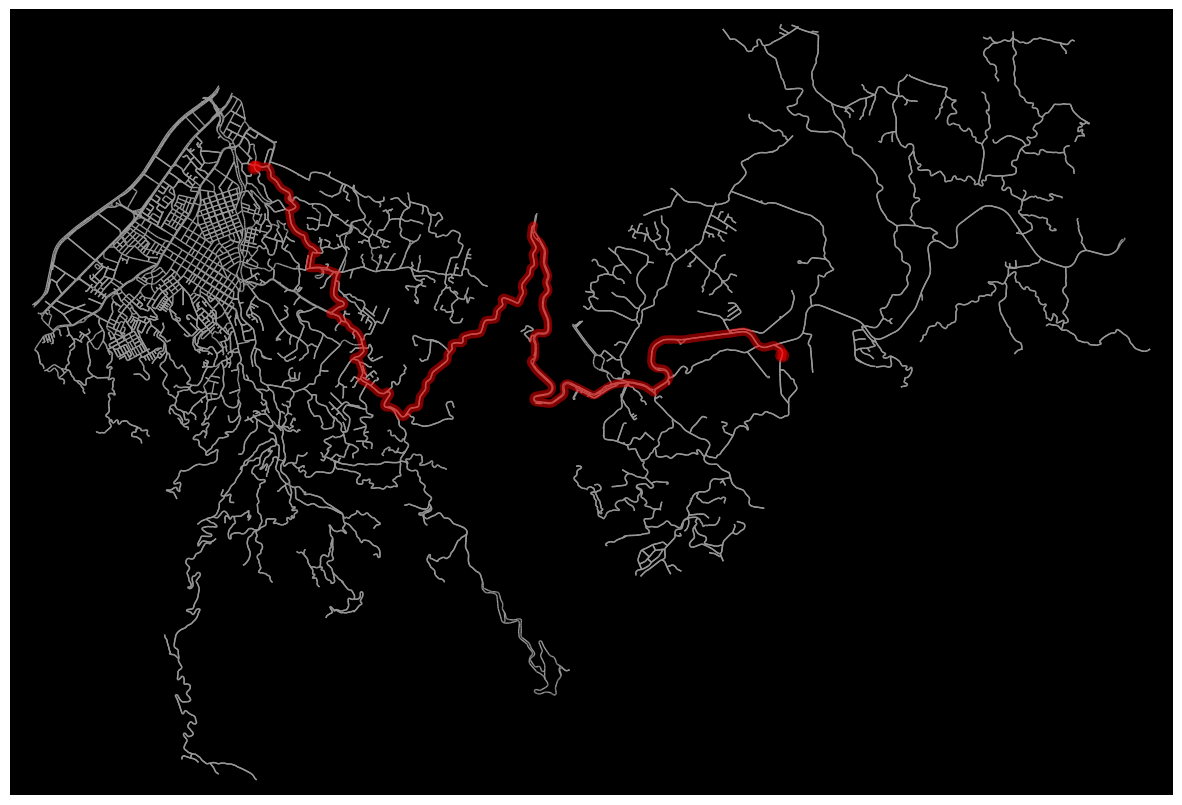

(<Figure size 1500x1500 with 1 Axes>, <Axes: >)

In [21]:
ox.plot_graph_route(G_proj, ruta_astar, route_linewidth=6, node_size=0, bgcolor='k', figsize=(15, 15))